In [34]:
# 使用bagging

import matplotlib.pyplot as plt

In [22]:
import tensorflow as tf
import numpy as np
import sklearn.feature_selection as fs

TRAIN_DATA_FILE = "train_data.csv"
TEST_DATA_FILE = "test_data.csv"


def read_split_train_test_data():
    training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
        filename=TRAIN_DATA_FILE,
        target_dtype=np.int,
        features_dtype=np.float32,
        target_column=0
    )
    test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
        filename=TEST_DATA_FILE,
        target_dtype=np.int,
        features_dtype=np.float32,
        target_column=0
    )
    # print(training_set)
    X, y = training_set.data, training_set.target
    # print(X.shape)
    # print(y.shape)
    X_test, y_test = test_set.data, test_set.target
    # print(X_test.shape)
    # print(y_test.shape)
    return X, y, X_test, y_test


def read_train_test_data():
    '''不把标签和数据分开'''
    x, y, x_t, y_t = read_split_train_test_data()
    y = y.reshape(x.shape[0], -1)
    # print(y.shape)
    y_t = y_t.reshape(x_t.shape[0], -1)
    x_train = np.concatenate((x, y), axis=1)
    x_test = np.concatenate((x_t, y_t), axis=1)
    # print(x_train.shape)
    return x_train, x_test


def split_data_label(X):
    '''将数据和标签分开,默认标签位于最后一列'''
    data, label = X[:, :-1], X[:, -1]
    return data, label


d_train, d_test = read_train_test_data()


In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from collections import Counter

In [17]:
X,y,X_test,y_test = read_split_train_test_data()
cls = BaggingClassifier(base_estimator=GaussianNB(),max_samples=1.0)

y_pred = cls.fit(X, y).predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
print(acc)

# 打乱数据集

cls = BaggingClassifier(base_estimator=GaussianNB(), max_samples=1.0)

indices = np.random.permutation(X.shape[0])  # shape[0]表示第0轴的长度，通常是训练数据的数量  
rand_data_x = X[indices]
rand_data_y = y[indices]  # data_y就是标记（label）  

y_pred = cls.fit(rand_data_x, rand_data_y).predict(X_test)
print(type(y_pred))
acc = metrics.accuracy_score(y_test, y_pred)
print(acc)

(10545, 28)
(10545,)
(300, 28)
(300,)
0.68
<class 'numpy.ndarray'>
0.683333333333


In [6]:
# 我打算将数据手动分开再分别训练

In [18]:
def split_class_1(data):
    X, y = split_data_label(data)
    # 提取出类别为1的数据
    X_1 = np.array([list(X[i]) for i in range(len(y)) if y[i] == 1])
    y_1 = np.array([y[i] for i in range(len(y)) if y[i] == 1])
    print(X_1.shape[0], y_1.shape[0])
    # 提取出类别不为1的数据
    X_n1 = np.array([list(X[i]) for i in range(len(y)) if y[i] != 1])
    y_n1 = np.array([y[i] for i in range(len(y)) if y[i] != 1])
    return X_1, y_1, X_n1, y_n1


7431 7431
(6, 300)
0.706666666667
{0.0: 9, 4.0: 15, 3.0: 12, 2.0: 26, 1.0: 20, 5.0: 6}
[0.1956521739130435, 0.2564102564102564, 0.4166666666666667, 0.22641509433962265, 0.5531914893617021, 0.15]


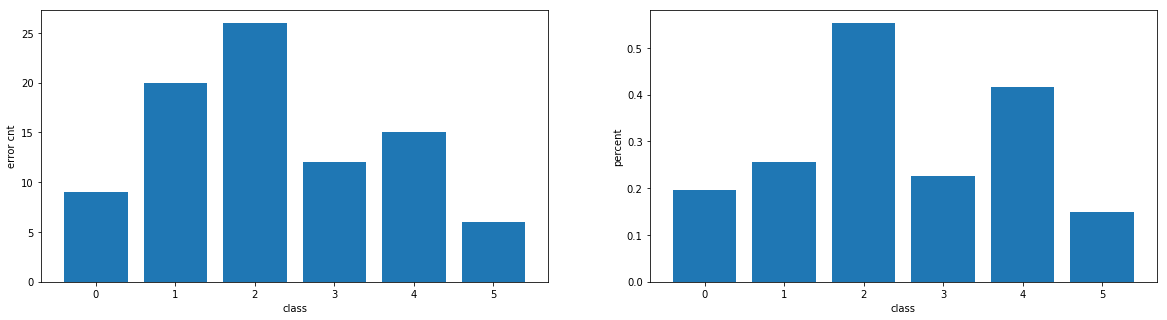

In [75]:
data, data_test = read_train_test_data()

np.random.shuffle(data)
X_test, y_test = split_data_label(data_test)

X_1, y_1, X_n1, y_n1 = split_class_1(data)
pred_record = []
y_pred = None
al = int(len(X_1) / 6)
gnb = GaussianNB()
for i in range(6):
    xt1 = X_1[i * al:(i + 1) * al, :]
    yt1 = y_1[i * al:(i + 1) * al]
    X_temp = np.concatenate((xt1, X_n1), axis=0)
    y_temp = np.concatenate((yt1, y_n1), axis=0)
    # print(temp.shape)
    if i == 0:
        y_pred = gnb.fit(X_temp, y_temp).predict(X_test)
    else:
        y_p = gnb.fit(X_temp, y_temp).predict(X_test)
        y_pred = np.concatenate((y_pred, y_p))

        # acc = metrics.accuracy_score(y_test, y_pred)
        # print(acc)
y_pred = y_pred.reshape(6, -1)
print(y_pred.shape)

col_len = y_pred.shape[1]
# col_len = 5
y_pred_final = []
for i in range(col_len):
    choose = Counter(list(y_pred[:, i])).most_common(1)[0][0]
    # print(choose)
    y_pred_final.append(choose)

acc = metrics.accuracy_score(y_test, y_pred_final)
print(acc)

# 看看预测值和测试值有哪些差别
cnt = {}
test_cnt = {}
for i in range(y_test.shape[0]):
    test_cnt[y_test[i]] = test_cnt.get(y_test[i], 0) + 1
    if y_pred_final[i] != y_test[i]:
        cnt[y_test[i]] = cnt.get(y_test[i], 0) + 1

print(cnt)
key = list(cnt.keys())
val = list(cnt.values())

# 计算每种类别预测错误的百分比
err_percent = []
for k in test_cnt.keys():
    err_percent.append(cnt.get(k, 0) / test_cnt.get(k))
print(err_percent)
plt.figure(1, figsize=(20, 5))
plt.subplot(121)
plt.bar(key, val)
plt.xlabel('class')
plt.ylabel('error cnt')
plt.subplot(122)
# plt.pie(err_percent, labels=list(test_cnt.keys()), autopct='%.2f')
plt.bar(list(test_cnt.keys()), err_percent)
plt.ylabel('percent')
plt.xlabel('class')
plt.show()


In [44]:

al = int(len(X_1) / 4)
gnb = GaussianNB()
for i in range(4):
    xt1 = X_1[i * al:(i + 1) * al, :]
    yt1 = y_1[i * al:(i + 1) * al]
    X_temp = np.concatenate((xt1, X_n1), axis=0)
    y_temp = np.concatenate((yt1, y_n1), axis=0)
    # print(temp.shape)
    y_pred = gnb.fit(X_temp, y_temp).predict(X_test)
    
    # 记录每个结果,最后会评比
    
    acc = metrics.accuracy_score(y_test, y_pred)
    print(acc)


0.696666666667
0.703333333333
0.703333333333
0.7
